In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image

In [2]:
labels_annotations = pd.read_csv('C:\\DATA\\Skin cancer-dataset\\GroundTruth.csv')
labels_annotations.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
labels_annotations['labels'] = ''

In [4]:
labels_annotations.loc[(labels_annotations['MEL'] != 0.0), 'labels'] = 'MEL'
labels_annotations.loc[(labels_annotations['NV'] != 0.0), 'labels'] = 'NV'
labels_annotations.loc[(labels_annotations['BCC'] != 0.0), 'labels'] = 'BCC'
labels_annotations.loc[(labels_annotations['AKIEC'] != 0.0), 'labels'] = 'AKIEC'
labels_annotations.loc[(labels_annotations['BKL'] != 0.0), 'labels'] = 'BKL'
labels_annotations.loc[(labels_annotations['DF'] != 0.0), 'labels'] = 'DF'
labels_annotations.loc[(labels_annotations['VASC'] != 0.0), 'labels'] = 'VASC'

In [5]:
labels = labels_annotations[['image', 'labels']]
labels.head()

,image,labels
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL


In [6]:
labels_list = list(labels.iloc[:,1])

In [11]:
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels_list)
targets = torch.as_tensor(targets)

In [12]:
targets

tensor([5, 5, 5,  ..., 2, 5, 5])

In [13]:
class SkinCancerDataset(torch.utils.data.Dataset):
    def __init__(self, targets, img_dir, mask_dir, transforms = None):
        self.targets = targets
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = list(sorted(os.listdir(os.path.join(self.img_dir))))
        self.masks = list(sorted(os.listdir(os.path.join(self.mask_dir))))
        self.transforms = transforms

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = Image.open(img_path)
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = Image.open(mask_path).convert("RGB")
        label = self.targets[idx]
        if self.transforms:
            img = self.transforms(img)
            mask = self.transforms(mask)
        return img, mask, label

In [14]:
transformations = T.Compose([T.ToTensor(), 
                             T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

In [15]:
data = SkinCancerDataset(targets, r'C:\DATA\Skin cancer-dataset\images', r'C:\DATA\Skin cancer-dataset\masks', 
                        transforms = transformations)

In [16]:
len(data)

10015

In [17]:
val_size = 0.3
val_inds = np.random.choice(len(data), size = int(val_size * len(data)), replace = False)
train_data_split = torch.utils.data.Subset(data, [i for i in range(len(data)) if i not in val_inds])
val_data_split = torch.utils.data.Subset(data, val_inds)
print(len(train_data_split), len(val_data_split))

7011 3004


In [18]:
train_dataloader = torch.utils.data.DataLoader(train_data_split, batch_size = 1, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_data_split, batch_size = 1, shuffle = False)

In [19]:
data[0]

(tensor([[[ 1.6667,  1.6838,  1.7009,  ...,  1.8037,  1.7523,  1.8208],
          [ 1.7009,  1.7352,  1.7865,  ...,  1.7352,  1.7523,  1.7523],
          [ 1.6838,  1.8037,  1.8379,  ...,  1.7180,  1.7694,  1.7865],
          ...,
          [ 1.4612,  1.4783,  1.5125,  ...,  1.4783,  1.4612,  1.4269],
          [ 1.3927,  1.4440,  1.4612,  ...,  1.4783,  1.5125,  1.4954],
          [ 1.4269,  1.4612,  1.4440,  ...,  1.4440,  1.4954,  1.4612]],
 
         [[ 0.2577,  0.2052,  0.2227,  ...,  0.3102,  0.3452,  0.3277],
          [ 0.2227,  0.2402,  0.2752,  ...,  0.3277,  0.3452,  0.3102],
          [ 0.2052,  0.2227,  0.2402,  ...,  0.3452,  0.3452,  0.3627],
          ...,
          [ 0.0301,  0.0476,  0.0826,  ...,  0.4153,  0.4328,  0.3978],
          [-0.0049,  0.0476,  0.0651,  ...,  0.4503,  0.4853,  0.4678],
          [-0.0049,  0.0651,  0.0651,  ...,  0.4678,  0.5203,  0.4853]],
 
         [[ 0.4788,  0.3916,  0.4091,  ...,  0.6008,  0.6008,  0.6182],
          [ 0.4439,  0.3916,

In [20]:
imgs, msks, labs = next(iter(train_dataloader))

In [21]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [22]:
def show_img(img_tensor, label):
    img = img_tensor.permute(1, 2, 0).numpy()
    img = std * img + mean
    plt.imshow(img.clip(0, 1))
    plt.title(class_names[label])
    plt.show()
    plt.pause(0.001)
def show_msk(msk_tensor, label):
    msk = msk_tensor.permute(1, 2, 0).numpy()
    msk = std * msk + mean
    plt.imshow(msk.clip(0, 1))
    plt.title(class_names[label])
    plt.show()
    plt.pause(0.001)

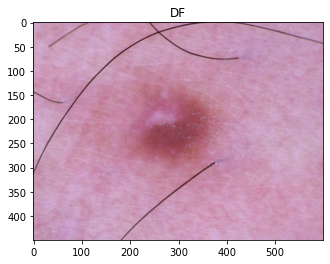

In [23]:
show_img(imgs[0], labs[0])

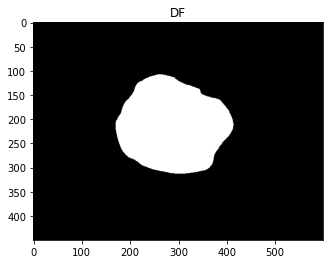

In [24]:
show_msk(msks[0], labs[0])

In [25]:
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
for param in model.parameters():
    param.requires_grad = False

In [28]:
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [29]:
num_classes = 7

In [30]:
model.classifier[4] = torch.nn.Conv2d(512, 7, 1, 1)

In [31]:
model.aux_classifier[4] = torch.nn.Conv2d(256, 7, 1, 1)

In [32]:
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [33]:
model = model.to(device)